In [58]:
# step 1, import moduels
import os, re
import pandas as pd
import numpy
import numpy as np
from scipy import stats
from scipy import math
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from scipy.stats.mstats import zscore
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# step 2, defines functions (may need to clean it up later)
def compute_correlation(matrix1, matrix2):
    """compute correlation between two sets of variables

    Correlate the rows of matrix1 with the rows of matrix2.
    If matrix1 == matrix2, it is auto-correlation computation
    resulting in a symmetric correlation matrix.
    The number of columns MUST agree between set1 and set2.
    The correlation being computed here is
    the Pearson's correlation coefficient, which can be expressed as

    .. math:: corr(X, Y) = \\frac{cov(X, Y)}{\\sigma_X\\sigma_Y}

    where cov(X, Y) is the covariance of variable X and Y, and

    .. math:: \\sigma_X

    is the standard deviation of variable X

    Reducing the correlation computation to matrix multiplication
    and using BLAS GEMM API wrapped by Scipy can speedup the numpy built-in
    correlation computation (numpy.corrcoef) by one order of magnitude

    .. math::
        corr(X, Y)
        &= \\frac{\\sum\\limits_{i=1}^n (x_i-\\bar{x})(y_i-\\bar{y})}{(n-1)
        \\sqrt{\\frac{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}{n-1}}
        \\sqrt{\\frac{\\sum\\limits_{j=1}^{n} y_j^2-n\\bar{y}}{n-1}}}\\\\
        &= \\sum\\limits_{i=1}^n(\\frac{(x_i-\\bar{x})}
        {\\sqrt{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}}
        \\frac{(y_i-\\bar{y})}{\\sqrt{\\sum\\limits_{j=1}^n y_j^2-n\\bar{y}}})

    Parameters
    ----------
    matrix1: 2D array in shape [r1, c]
        MUST be continuous and row-major

    matrix2: 2D array in shape [r2, c]
        MUST be continuous and row-major

    Returns
    -------
    corr_data: 2D array in shape [r1, r2]
        continuous and row-major in np.float32
    """
    matrix1 = matrix1.astype(np.float32)
    matrix2 = matrix2.astype(np.float32)
    [r1, d1] = matrix1.shape
    [r2, d2] = matrix2.shape
    if d1 != d2:
        raise ValueError('Dimension discrepancy')
    # preprocess two components
    matrix1 = _normalize_for_correlation(matrix1, 1)
    matrix2 = _normalize_for_correlation(matrix2, 1)
    #print(matrix1.shape)
    #print(matrix2.shape)
    corr_data = np.corrcoef(matrix1, matrix2)
    #print(corr_data.shape)
    #print(d1)
    return corr_data[:r1, r1:]   ###I Believe this is the critical part! we need to fix this and then should be fine
    #According to my understanding, the submatrices AAA[0:90, 0:90]  and AAA[90:,90:] will be the respective "intra-brain" 
    #correlations. What we want is the one that goes across brains, i.e. the lower/upper quadrant. This should be relatively
    #easy to formalize. i.e. corr_data[:r1, r1:]  should be 0:90 rows, but 90:180 columns, which should be the across brain computation.



def _normalize_for_correlation(data, axis):
    """normalize the data before computing correlation
    The data will be z-scored and divided by sqrt(n)
    along the assigned axis
    Parameters
    ----------
    data: 2D array
    axis: int
        specify which dimension of the data should be normalized
    Returns
    -------
    data: 2D array
        the normalized data
    """
    shape = data.shape
    data = zscore(data, axis=axis, ddof=0)
    # if zscore fails (standard deviation is zero),
    # set all values to be zero
    data = np.nan_to_num(data)
    data = data / math.sqrt(shape[axis])
    return data



def isc(D, collapse_subj=True):
    """Intersubject correlation

    For each voxel, computes the correlation of each subject's timecourse with
    the mean of all other subjects' timecourses. By default the result is
    averaged across subjects, unless collapse_subj is set to False.

    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISC

    collapse_subj : bool, default:True
        Whether to average across subjects before returning result

    Returns
    -------
    ISC : voxel ndarray (or voxel by subject ndarray, if collapse_subj=False)
        pearson correlation for each voxel, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISC = np.zeros((n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(n_subj):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        for v in range(n_vox):
            ISC[v, loo_subj] = stats.pearsonr(group[v, :], subj[v, :])[0]

    if collapse_subj:
        ISC = np.mean(ISC, axis=1)
    return ISC


def isfc(D, collapse_subj=True):
    """Intersubject functional correlation
    Computes the correlation between the timecoure of each voxel in each
    subject with the average of all other subjects' timecourses in *all*
    voxels. By default the result is averaged across subjects, unless
    collapse_subj is set to False.
    Uses the high performance compute_correlation routine from fcma.util
    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISFC
    collapse_subj : bool, default:True
        Whether to average across subjects before returning result
    Returns
    -------
    ISFC : voxel by voxel ndarray
        (or voxel by voxel by subject ndarray, if collapse_subj=False)
        pearson correlation between all pairs of voxels, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISFC = np.zeros((n_vox, n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(D.shape[2]):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        ISFC[:, :, loo_subj] = compute_correlation(group, subj)

        # Symmetrize matrix
        ISFC[:, :, loo_subj] = (ISFC[:, :, loo_subj] +
                                ISFC[:, :, loo_subj].T) / 2

    if collapse_subj:
        ISFC = np.mean(ISFC, axis=2)
    return ISFC

def psa_isfc(pID, vID):
    same_spots = [s for s in os.listdir(data_dir) if s.endswith('_' + vID + '_realcost01.npz')]

    #re-load extracted data
    data_list = []
    for i in same_spots:
        d = np.load(i)
        data_list.append(d['arr_0'][:tr,:])
    
    #stack them into a 3d array and set up array to have the dimenion order that ISFC wants
    spot_data  = np.asarray(data_list)  
    #    D : voxel by time by subject ndarray = that's what ISFC wants - so let's swap axes
    spot_data_v_t_s = spot_data.swapaxes(0,2)
    spot_data_v_t_s.shape

    result_isfc = isfc(spot_data_v_t_s, collapse_subj= False)
    
    return(result_isfc[:,:,subjs.index(pID)])

In [61]:
# step 3: define nodes, and networks
networks_labels = [' anterior_Salience1', ' anterior_Salience2', ' anterior_Salience3', 
                   ' anterior_Salience4', ' anterior_Salience5', ' anterior_Salience6', 
                   ' anterior_Salience7', ' Auditory1', ' Auditory2', ' Auditory3', 
                   ' Basal_Ganglia1', ' Basal_Ganglia2', ' Basal_Ganglia3', ' Basal_Ganglia4', 
                   ' Basal_Ganglia5', ' dorsal_DMN1', ' dorsal_DMN2', ' dorsal_DMN3', 
                   ' dorsal_DMN4', ' dorsal_DMN5', ' dorsal_DMN6', ' dorsal_DMN7', 
                   ' dorsal_DMN8', ' dorsal_DMN9', ' high_Visual1', ' high_Visual2', 
                   ' Language1', ' Language2', ' Language3', ' Language4', ' Language5', 
                   ' Language6', ' Language7', ' LECN1', ' LECN2', ' LECN3', ' LECN4', 
                   ' LECN5', ' LECN6', ' post_Salience1', ' post_Salience2', ' post_Salience3', 
                   ' post_Salience4', ' post_Salience5', ' post_Salience6', ' post_Salience7', 
                   ' post_Salience8', ' post_Salience9', ' post_Salience10', ' post_Salience11',
                   ' post_Salience12', ' Precuneus1', ' Precuneus2', ' Precuneus3', 
                   ' Precuneus4', ' prim_Visual1', ' prim_Visual2', ' RECN1', ' RECN2', 
                   ' RECN3', ' RECN4', ' RECN5', ' RECN6', ' Sensorimotor1', ' Sensorimotor2', 
                   ' Sensorimotor3', ' Sensorimotor4', ' Sensorimotor5', ' Sensorimotor6', 
                   ' ventral_DMN1', ' ventral_DMN2', ' ventral_DMN3', ' ventral_DMN4', 
                   ' ventral_DMN5', ' ventral_DMN6', ' ventral_DMN7', ' ventral_DMN8', 
                   ' ventral_DMN9', ' ventral_DMN10', ' Visuospatial1', ' Visuospatial2', 
                   ' Visuospatial3', ' Visuospatial4', ' Visuospatial5', ' Visuospatial6', 
                   ' Visuospatial7', ' Visuospatial8', ' Visuospatial9', ' Visuospatial10', 
                   ' Visuospatial11']

networks = {"anterior_salience":[0,6], "anterior_salience": [0, 6], "auditory": [7, 9],
"basal ganglia": [10,14], "Dorsal_DMN": [15 , 23], "LECN": [33, 38], "RECN": [57, 62], "Precuneus": [51, 54]}


In [69]:
#step 4, set up
data_dir = '/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/shirer90spheres8mm_hyp/'
os.chdir(data_dir)
subjs = ['PSA156', 'PSA019', 'PSA144', 'PSA061', 'PSA120', 'PSA032', 'PSA041', 'PSA079', 'PSA029', 
         'PSA036', 'PSA078', 'PSA086', 'PSA131', 'PSA132', 'PSA153', 'PSA112', 'PSA056', 'PSA068', 
         'PSA075', 'PSA108', 'PSA003', 'PSA005', 'PSA007', 'PSA008', 'PSA009', 'PSA010', 'PSA016', 
         'PSA017', 'PSA026', 'PSA027', 'PSA028', 'PSA030', 'PSA109', 'PSA069', 'PSA119', 'PSA128', 
         'PSA142', 'PSA094', 'PSA151', 'PSA127']

tr = 31
print(len(subjs)) # check the number of subjs that we have
#os.listdir(data_dir)

df = pd.read_csv("/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/datasheets/qualtrics_intention_beliefchange.csv").set_index('pID')

networks_file = '/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/datasheets/networks_coords_names.pckl'

with open(networks_file, "rb") as f:
    networks_labels, networks_coords, networks_inds,module_idx, breakpoints, network_borders, \
    netnames, bounds, bp, textlocs, networks_xyz_coords,  cmap_list, col_vec  = pickle.load(f, encoding='latin1')
n_nodes = len(networks_coords)                 

40


In [70]:
# seperate into groups, 
skin_dict = df['b_wrinkles_change'].to_dict()
print(skin_dict)
# participants only shift their belief by 1 or none at all

skin_pos_idx = df.loc[df.b_wrinkles_change > 0, 'b_wrinkles_change'].index.tolist()
skin_pos_idx.remove("PSA154")
skin_same_idx = df.loc[df.b_wrinkles_change == 0, 'b_wrinkles_change'].index.tolist()
skin_same_idx.remove("PSA038")
skin_same_idx.remove("PSA093")


skin_neg_idx = df.loc[df.b_wrinkles_change < 0, 'b_wrinkles_change'].index.tolist()

skin_pos = {}
skin_same = {}
skin_neg = {}
skin_change = {}

#get df for each group
for subj in skin_pos_idx:
    skin_pos[subj] = psa_isfc(subj,'1').flatten().tolist()
df_pos_skin = pd.DataFrame.from_dict(data=skin_pos)
df_pos_skin = pd.DataFrame.transpose(df_pos_skin)

for subj in skin_same_idx:
    skin_same[subj] = psa_isfc(subj,'1').flatten().tolist()
df_same_skin = pd.DataFrame.from_dict(data=skin_same)
df_same_skin = pd.DataFrame.transpose(df_same_skin)

for subj in skin_neg_idx:
    skin_neg[subj] = psa_isfc(subj,'1').flatten().tolist()
df_neg_skin = pd.DataFrame.from_dict(data=skin_pos)
df_neg_skin = pd.DataFrame.transpose(df_neg_skin)

for subj in skin_neg_idx + skin_pos_idx:
    skin_change[subj] = psa_isfc(subj,'1').flatten().tolist()
df_change_skin = pd.DataFrame.from_dict(data=skin_change)
df_change_skin = pd.DataFrame.transpose(df_change_skin)


## okay, let's first do a contrast of belief change vs. no belief change
skin_t = []
for i in range(8100):
    r = stats.ttest_ind(df_change_skin[i].tolist(),df_same_skin[i].tolist())
    skin_t.append(r[0])

skin_t_map = np.reshape(skin_t, (90, 90))

{'PSA003': 1, 'PSA005': 0, 'PSA007': 0, 'PSA008': 0, 'PSA009': 1, 'PSA010': 1, 'PSA016': 0, 'PSA017': 0, 'PSA019': 0, 'PSA026': 0, 'PSA027': 0, 'PSA028': 0, 'PSA029': 1, 'PSA030': -1, 'PSA032': 0, 'PSA036': 0, 'PSA038': 0, 'PSA041': -1, 'PSA056': 1, 'PSA061': 0, 'PSA068': 1, 'PSA069': -1, 'PSA075': 0, 'PSA078': 1, 'PSA079': -1, 'PSA086': 0, 'PSA093': 0, 'PSA094': 0, 'PSA108': 0, 'PSA109': 0, 'PSA112': -1, 'PSA119': 1, 'PSA120': 1, 'PSA127': 0, 'PSA128': 0, 'PSA131': 0, 'PSA132': 1, 'PSA142': 0, 'PSA144': 0, 'PSA151': 0, 'PSA153': 0, 'PSA154': 1, 'PSA156': 0}


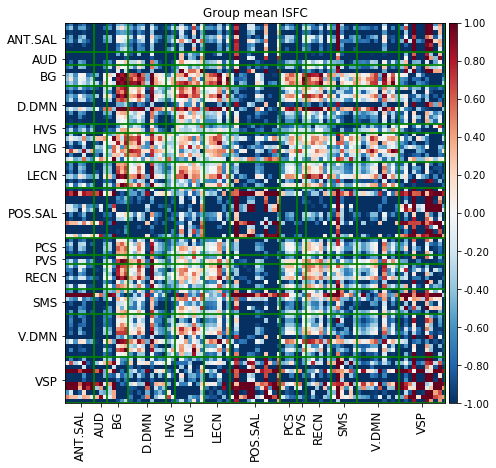

In [71]:
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot(111) 

im3 = ax1.imshow(skin_t_map[:,:],interpolation='none',cmap='RdBu_r', vmax = 1, vmin=-1);
ax1.set_title('Group mean ISFC');

bounds = bp


ax1.grid(False);
divider3 = make_axes_locatable(ax1)
    # Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="2%", pad=0.05)
    # Create colorbar in the appended axes
    # Tick locations can be set with the kwarg `ticks`
    # and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(0.2), format="%.2f")
    
#ax.colorbar(shrink=0.5);
ax1.set_yticks(textlocs);
ax1.set_yticklabels(netnames,fontsize=12);
ax1.set_xticks(textlocs);
ax1.set_xticklabels(netnames,fontsize=12,rotation=90);    


for b in bounds:
        ax1.axvline(x=b,color='green', linewidth = 1.75)
        ax1.axhline(y=b,color='green', linewidth = 1.75)


plt.tight_layout()

In [72]:
# we try the same thing with teeth

In [76]:
teeth_dict = df['b_teeth_change'].to_dict()
print(teeth_dict)
# participants only shift their belief by 1 or none at all

teeth_pos_idx = df.loc[df.b_teeth_change > 0, 'b_teeth_change'].index.tolist()
teeth_pos_idx.remove("PSA093")
teeth_pos_idx.remove("PSA154")
teeth_same_idx = df.loc[df.b_teeth_change == 0, 'b_teeth_change'].index.tolist()
teeth_same_idx.remove("PSA038")
teeth_neg_idx = df.loc[df.b_teeth_change < 0, 'b_teeth_change'].index.tolist()

teeth_pos = {}
teeth_same = {}
teeth_neg = {}
teeth_change = {}



for subj in teeth_pos_idx:
    teeth_pos[subj] = psa_isfc(subj,'2').flatten().tolist()
df_pos_teeth = pd.DataFrame.from_dict(data=teeth_pos)
df_pos_teeth = pd.DataFrame.transpose(df_pos_teeth)

for subj in teeth_same_idx:
    teeth_same[subj] = psa_isfc(subj,'2').flatten().tolist()
df_same_teeth = pd.DataFrame.from_dict(data=teeth_same)
df_same_teeth = pd.DataFrame.transpose(df_same_teeth)

for subj in teeth_neg_idx:
    teeth_neg[subj] = psa_isfc(subj,'2').flatten().tolist()
df_neg_teeth = pd.DataFrame.from_dict(data=teeth_neg)
df_neg_teeth = pd.DataFrame.transpose(df_neg_teeth)


for subj in teeth_neg_idx + teeth_pos_idx:
    teeth_change[subj] = psa_isfc(subj,'2').flatten().tolist()
df_change_teeth = pd.DataFrame.from_dict(data=teeth_change)
df_change_teeth = pd.DataFrame.transpose(df_change_teeth)



teeth_t = []
for i in range(8100):
    r = stats.ttest_ind(df_change_teeth[i].tolist(),df_same_teeth[i].tolist())
    teeth_t.append(r[0])

teeth_t_map = np.reshape(teeth_t, (90, 90))

{'PSA003': 0, 'PSA005': -1, 'PSA007': 0, 'PSA008': 0, 'PSA009': 0, 'PSA010': 0, 'PSA016': 1, 'PSA017': 0, 'PSA019': 1, 'PSA026': -1, 'PSA027': 0, 'PSA028': -1, 'PSA029': 0, 'PSA030': -1, 'PSA032': 0, 'PSA036': 1, 'PSA038': 0, 'PSA041': 0, 'PSA056': 0, 'PSA061': 0, 'PSA068': 0, 'PSA069': 0, 'PSA075': 0, 'PSA078': 1, 'PSA079': 1, 'PSA086': 0, 'PSA093': 1, 'PSA094': 1, 'PSA108': 0, 'PSA109': -1, 'PSA112': 0, 'PSA119': 0, 'PSA120': -1, 'PSA127': 0, 'PSA128': 0, 'PSA131': 0, 'PSA132': 0, 'PSA142': 0, 'PSA144': 0, 'PSA151': 0, 'PSA153': -1, 'PSA154': 1, 'PSA156': 0}


In [77]:
#teeth_t_map = teeth_t_map - 0.4

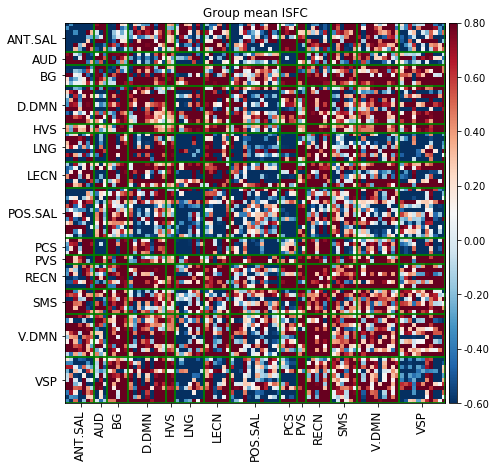

In [78]:
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot(111) 

im3 = ax1.imshow(teeth_t_map[:,:],interpolation='none',cmap='RdBu_r', vmax = 0.8, vmin=-0.6);
ax1.set_title('Group mean ISFC');

bounds = bp


ax1.grid(False);
divider3 = make_axes_locatable(ax1)
    # Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="2%", pad=0.05)
    # Create colorbar in the appended axes
    # Tick locations can be set with the kwarg `ticks`
    # and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(0.2), format="%.2f")
    
#ax.colorbar(shrink=0.5);
ax1.set_yticks(textlocs);
ax1.set_yticklabels(netnames,fontsize=12);
ax1.set_xticks(textlocs);
ax1.set_xticklabels(netnames,fontsize=12,rotation=90);    


for b in bounds:
        ax1.axvline(x=b,color='green', linewidth = 1.75)
        ax1.axhline(y=b,color='green', linewidth = 1.75)


plt.tight_layout()

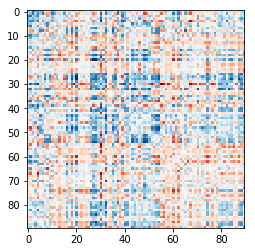

In [25]:
plt.imshow(teeth_t_map, interpolation='none',cmap='RdBu_r', );

In [42]:
df = pd.read_csv("/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/datasheets/qualtrics_intention_beliefchange.csv").set_index('pID')
df.loc[df.b_teeth_change == 1, 'b_teeth_change'].index.tolist()
teeth_dict = df['b_teeth_change'].to_dict()
teeth_dict

{'PSA003': 0,
 'PSA005': -1,
 'PSA007': 0,
 'PSA008': 0,
 'PSA009': 0,
 'PSA010': 0,
 'PSA016': 1,
 'PSA017': 0,
 'PSA019': 1,
 'PSA026': -1,
 'PSA027': 0,
 'PSA028': -1,
 'PSA029': 0,
 'PSA030': -1,
 'PSA032': 0,
 'PSA036': 1,
 'PSA038': 0,
 'PSA041': 0,
 'PSA056': 0,
 'PSA061': 0,
 'PSA068': 0,
 'PSA069': 0,
 'PSA075': 0,
 'PSA078': 1,
 'PSA079': 1,
 'PSA086': 0,
 'PSA093': 1,
 'PSA094': 1,
 'PSA108': 0,
 'PSA109': -1,
 'PSA112': 0,
 'PSA119': 0,
 'PSA120': -1,
 'PSA127': 0,
 'PSA128': 0,
 'PSA131': 0,
 'PSA132': 0,
 'PSA142': 0,
 'PSA144': 0,
 'PSA151': 0,
 'PSA153': -1,
 'PSA154': 1,
 'PSA156': 0}

In [43]:
df = pd.read_csv("/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/datasheets/qualtrics_intention_beliefchange.csv").set_index('pID')
df.loc[df.b_chemicals_change == 1, 'b_teeth_change'].index.tolist()
chemicals_dict = df['b_chemicals_change'].to_dict()
chemicals_dict

{'PSA003': 0,
 'PSA005': 0,
 'PSA007': -1,
 'PSA008': 0,
 'PSA009': 0,
 'PSA010': 0,
 'PSA016': 1,
 'PSA017': -1,
 'PSA019': -1,
 'PSA026': -1,
 'PSA027': 0,
 'PSA028': 0,
 'PSA029': 0,
 'PSA030': -1,
 'PSA032': 0,
 'PSA036': 0,
 'PSA038': 0,
 'PSA041': 0,
 'PSA056': 0,
 'PSA061': 0,
 'PSA068': 0,
 'PSA069': 1,
 'PSA075': 0,
 'PSA078': 0,
 'PSA079': 0,
 'PSA086': 0,
 'PSA093': 1,
 'PSA094': 1,
 'PSA108': 0,
 'PSA109': 1,
 'PSA112': 0,
 'PSA119': 0,
 'PSA120': -1,
 'PSA127': 0,
 'PSA128': 0,
 'PSA131': 0,
 'PSA132': 0,
 'PSA142': -1,
 'PSA144': 0,
 'PSA151': 0,
 'PSA153': 0,
 'PSA154': 0,
 'PSA156': 0}

In [161]:
teeth_neg_idx

['PSA005', 'PSA026', 'PSA028', 'PSA030', 'PSA109', 'PSA120', 'PSA153']

In [162]:
teeth_pos_idx

['PSA016', 'PSA019', 'PSA036', 'PSA078', 'PSA079', 'PSA094']

In [163]:
teeth_same_idx

['PSA003',
 'PSA007',
 'PSA008',
 'PSA009',
 'PSA010',
 'PSA017',
 'PSA027',
 'PSA029',
 'PSA032',
 'PSA041',
 'PSA056',
 'PSA061',
 'PSA068',
 'PSA069',
 'PSA075',
 'PSA086',
 'PSA108',
 'PSA112',
 'PSA119',
 'PSA127',
 'PSA128',
 'PSA131',
 'PSA132',
 'PSA142',
 'PSA144',
 'PSA151',
 'PSA156']